In [21]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import combinations
from xgboost import XGBClassifier

In [3]:
# load the data
mnist = fetch_openml('mnist_784')

/opt/homebrew/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
# data
X = mnist.data.to_numpy() / 255.0

# target
y = mnist.target.to_numpy().astype(int)

In [14]:
def load_data():
    """
    Load the data and split it into training and testing sets, then transpose them
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42)
    X_train = X_train.T
    X_test = X_test.T
    return X_train, y_train, X_test, y_test


def one_hot(Y):
    """
    Convert the target to one-hot encoding for the output layer, with each column representing a digit
    """
    Y_one_hot = np.zeros((Y.size, Y.max() + 1))
    Y_one_hot[np.arange(Y.size), Y] = 1
    return Y_one_hot.T


def accuracy(y, y_hat):
    """
    Calculate the accuracy of the model as the number of correct predictions divided by the total number of predictions
    """
    return np.sum(y == y_hat) / y.size


def predict(A_final):
    """
    Predict the digit with the highest probability for each image
    """
    return np.argmax(A_final, axis=0)


def relu(x):
    """
    Rectified Linear Unit (ReLU) activation function
    """
    return np.maximum(0, x)

def drelu(x):
    """
    Derivative of the ReLU activation function
    """
    return x > 0


def softmax(x):
    """
    Softmax activation function
    """
    exp = np.exp(x - np.max(x, axis=0))
    return exp / np.sum(exp, axis=0)


def initialize_params(layers):
    """
    Initialize the weights and biases for each layer
    """

    # W_arr list of weight matrices
    W_arr = [np.random.rand(layers[i], layers[i-1]) - 0.5 for i in range(1, len(layers))]

    # b_arr list of bias vectors
    b_arr = [np.random.rand(layers[i], 1) - 0.5 for i in range(1, len(layers))]
    return W_arr, b_arr


def prop(X, W_arr, b_arr):
    """
    Forward propagation through the network
    """
    Z_arr, A_arr = [], []
    A = X
    
    # Loop through all layers except the last one
    for i in range(len(W_arr)):

        # Z = W * A + b
        Z = W_arr[i] @ A + b_arr[i]

        # A = g(Z) where g is the activation function
        if i == len(W_arr) - 1:

            # Use softmax for the output layer
            A = softmax(Z)
        else:

            # Use ReLU for the hidden layers
            A = relu(Z)
        Z_arr.append(Z)
        A_arr.append(A)

    return Z_arr, A_arr


def back_prop(y, X, W_arr, A_arr, Z_arr):
    """
    Backward propagation through the network
    """

    # m is the number of labels
    m = y.size
    inv = 1 / m
    # dW_arr and db_arr are the gradients of the cost function with respect to W and b
    dW_arr, db_arr = [], []

    # Initial dZ
    dZ = A_arr[-1] - one_hot(y)

    # Loop through all layers
    for i in range(len(W_arr) - 1, -1, -1):

        # use X.T for the first layer, A_arr[i-1].T for the rest
        if i == 0:
            dW = inv * dZ @ X.T
        else:
            dW = inv * dZ @ A_arr[i - 1].T

        # db is the mean of dZ
        db = inv * np.sum(dZ, axis=1, keepdims=True)

        # Add the gradients to the lists
        dW_arr.append(dW)
        db_arr.append(db)

        # If we are at the first layer, break
        if i == 0:
            break

        # Update dZ for the next iteration
        dZ = W_arr[i].T @ dZ * drelu(Z_arr[i-1])

    return dW_arr[::-1], db_arr[::-1]



def update_params(W_arr, b_arr, dW_arr, db_arr, alpha):
    """
    Update the weights and biases using the gradients and the learning rate
    """
    for i in range(len(W_arr)):
        W_arr[i] -= alpha * dW_arr[i]
        b_arr[i] -= alpha * db_arr[i]
    return W_arr, b_arr


def descent(X, y, alpha, epochs):
    """
    Perform gradient descent on the network
    """

    # Initialize the weights and biases with the given layer sizes
    W_arr, b_arr = initialize_params([784, 300, 200, 10])

    for i in range(epochs):

        # Forward and backward propagation
        Z_arr, A_arr = prop(X, W_arr, b_arr)
        dW_arr, db_arr = back_prop(y, X, W_arr, A_arr, Z_arr)

        # Update the weights and biases
        W_arr, b_arr = update_params(W_arr, b_arr, dW_arr, db_arr, alpha)

        # Print the accuracy every 10 epochs
        if i % 10 == 0:
            print('Epoch: ', i)
            print('Accuracy: ', accuracy(y, predict(A_arr[-1])))
    return W_arr, b_arr


X_train, y_train, X_test, y_test = load_data()
w, b = descent(X_train, y_train, 0.1, 200)

Epoch:  0
Accuracy:  0.109
Epoch:  10
Accuracy:  0.6209
Epoch:  20
Accuracy:  0.722
Epoch:  30
Accuracy:  0.7650833333333333
Epoch:  40
Accuracy:  0.7899
Epoch:  50
Accuracy:  0.8072666666666667
Epoch:  60
Accuracy:  0.8203333333333334
Epoch:  70
Accuracy:  0.8305666666666667
Epoch:  80
Accuracy:  0.8392
Epoch:  90
Accuracy:  0.8467
Epoch:  100
Accuracy:  0.8536333333333334
Epoch:  110
Accuracy:  0.85945
Epoch:  120
Accuracy:  0.86465
Epoch:  130
Accuracy:  0.86915
Epoch:  140
Accuracy:  0.8732166666666666
Epoch:  150
Accuracy:  0.8768666666666667
Epoch:  160
Accuracy:  0.8802833333333333
Epoch:  170
Accuracy:  0.8830833333333333
Epoch:  180
Accuracy:  0.8860666666666667
Epoch:  190
Accuracy:  0.8887


In [16]:
# download the w and b lists
for i,weight in enumerate(w):
    np.save('weight_'+str(i)+'.npy', weight)
for i,bias in enumerate(b):
    np.save('bias_'+str(i)+'.npy', bias)

Accuracy on test set:  0.8785
Prediction:  [2]
Label:  2


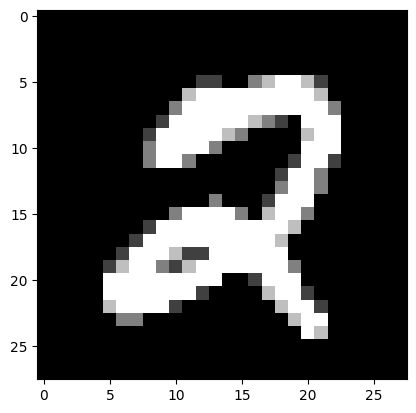

Prediction:  [4]
Label:  4


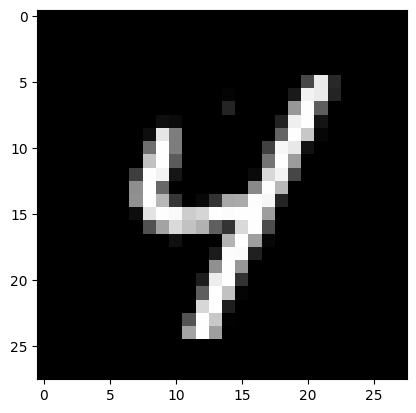

Prediction:  [0]
Label:  0


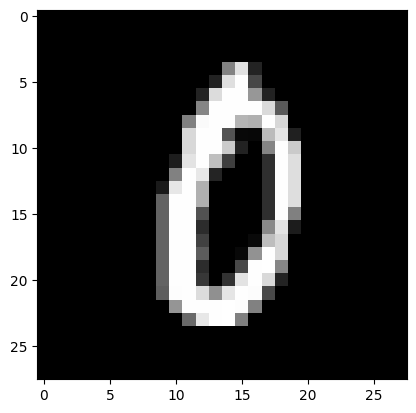

Prediction:  [1]
Label:  1


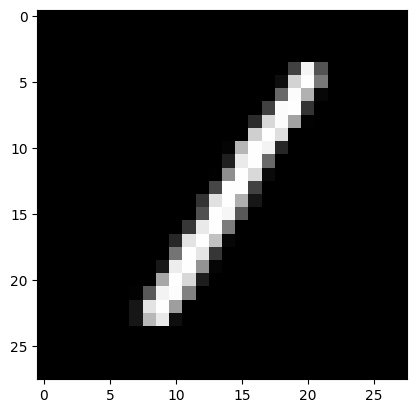

Prediction:  [6]
Label:  6


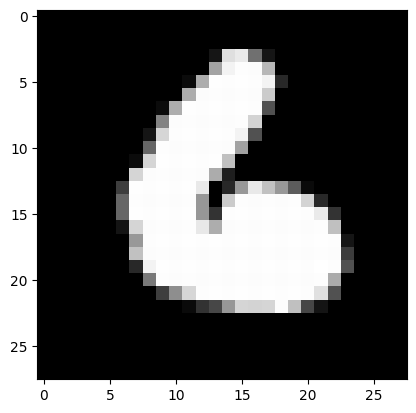

In [19]:
def make_prediction(X, W_arr, b_arr):
    _, A_arr = prop(X, W_arr, b_arr)
    return predict(A_arr[-1])

def test_prediction(index, W_arr, b_arr):
    current_image = X_train[:, index, None]
    prediction = make_prediction(current_image, W_arr, b_arr)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
# make prediction on test set
y_hat = make_prediction(X_test, w, b)
print('Accuracy on test set: ', accuracy(y_test, y_hat))
for i in range(5):
    test_prediction(i, w, b)

In [20]:
X_train, y_train, X_test, y_test = load_data()
iterating_nums = list(range(10))
combos = list(combinations(iterating_nums, 2))
difficulties = {}
for i in range(len(combos)):
    first, second = combos[i]
    new_test = X_test[:, np.logical_or(y_test == first, y_test == second)]
    new_label = y_test[np.logical_or(y_test == first, y_test == second)]

    acc = accuracy(new_label, make_prediction(new_test, w, b))
    # check the accuracy of the model on the test set
    difficulties[(first, second)] = acc

# find the combination with the lowest accuracy
lowest_acc = min(difficulties.values())
hardest_combination = list(difficulties.keys())[list(difficulties.values()).index(lowest_acc)]
print(f'The hardest combination is {hardest_combination} with an accuracy of {lowest_acc}')

# find the second hardest combination
del difficulties[hardest_combination]
lowest_acc = min(difficulties.values())
hardest_combination = list(difficulties.keys())[list(difficulties.values()).index(lowest_acc)]
print(f'The second hardest combination is {hardest_combination} with an accuracy of {lowest_acc}')


The hardest combination is (5, 8) with an accuracy of 0.8205666316894019
The second hardest combination is (8, 9) with an accuracy of 0.829426433915212


## This is great, but let's compare it to XGBoost

In [22]:
# train an XGBoost model
X_train, y_train, X_test, y_test = load_data()
clf = XGBClassifier()
clf.fit(X_train.T, y_train)
print('Accuracy: ', clf.score(X_test.T, y_test))

Accuracy:  0.9785


In [24]:
iterating_nums = list(range(10))
combos = list(combinations(iterating_nums, 2))
difficulties = {}
for i in range(len(combos)):
    first, second = combos[i]
    new_test = X_test[:, np.logical_or(y_test == first, y_test == second)]
    new_label = y_test[np.logical_or(y_test == first, y_test == second)]

    acc = clf.score(new_test.T, new_label)
    difficulties[(first, second)] = acc

# find the combination with the lowest accuracy
lowest_acc = min(difficulties.values())
hardest_combination = list(difficulties.keys())[list(difficulties.values()).index(lowest_acc)]
print(f'The hardest combination is {hardest_combination} with an accuracy of {lowest_acc}')

# find the second hardest combination
del difficulties[hardest_combination]
lowest_acc = min(difficulties.values())
hardest_combination = list(difficulties.keys())[list(difficulties.values()).index(lowest_acc)]
print(f'The second hardest combination is {hardest_combination} with an accuracy of {lowest_acc}')

The hardest combination is (8, 9) with an accuracy of 0.9680798004987531
The second hardest combination is (3, 9) with an accuracy of 0.9705314009661836
